In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import cv2
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import SGD
from sklearn.utils import shuffle
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import GaussianNB
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
from keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import roc_auc_score, roc_curve

Dataset Link: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

In [2]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)
# Set the number of classes
num_classes = 2

# Set the image size and other parameters
batch_size = 32

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
train = get_training_data('/content/drive/MyDrive/chest_xray/chest_xray/train')
test = get_training_data('/content/drive/MyDrive/chest_xray/chest_xray/test')
val = get_training_data('/content/drive/MyDrive/chest_xray/chest_xray/val')

OpenCV(4.7.0) /io/opencv/modules/imgproc/src/resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.7.0) /io/opencv/modules/imgproc/src/resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



<ipython-input-2-dc1165961153>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


OpenCV(4.7.0) /io/opencv/modules/imgproc/src/resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.7.0) /io/opencv/modules/imgproc/src/resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



<Axes: ylabel='count'>

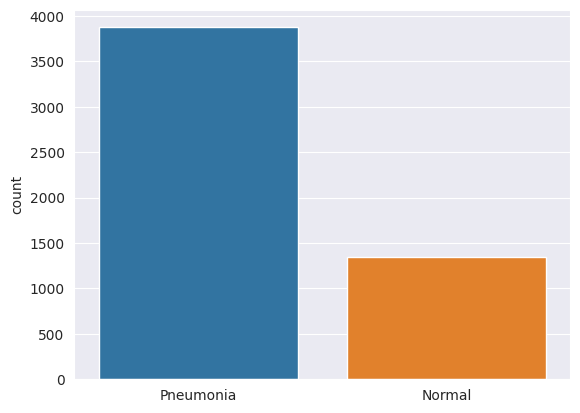

In [5]:
labels = []
for _, label in train:
    if label == 0:
        labels.append("Pneumonia")
    else:
        labels.append("Normal")

sns.set_style('darkgrid')
sns.countplot(x=labels)

Text(0.5, 1.0, 'Pneumonia')

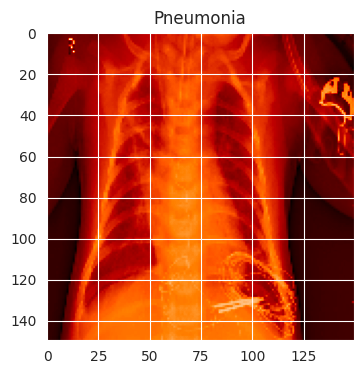

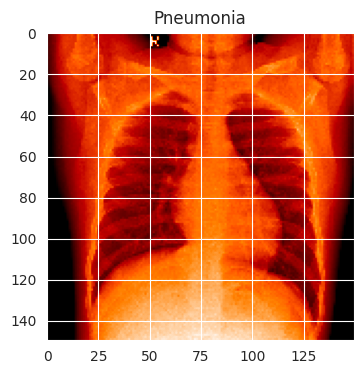

In [6]:
plt.figure(figsize = (4,4))
plt.imshow(train[0][0], cmap='gist_heat')
plt.title(labels[train[0][1]])

plt.figure(figsize = (4,4))
plt.imshow(train[-1][0], cmap='gist_heat')
plt.title(labels[train[-1][1]])

In [7]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)

for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [8]:
# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [9]:
# resize data for deep learning
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [10]:
# With data augmentation to prevent overfitting and handling the imbalance in dataset

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [11]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 150, 150, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 75, 75, 64)       2

In [12]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [13]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 12,
                    validation_data = datagen.flow(x_val, y_val) ,callbacks = [learning_rate_reduction])

Epoch 1/12
163/163 [==============================] - 408s 2s/step - loss: 0.5725 - accuracy: 0.8428 - val_loss: 27.7976 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/12
163/163 [==============================] - 411s 3s/step - loss: 0.2673 - accuracy: 0.8995 - val_loss: 37.1182 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/12
163/163 [==============================] - 415s 3s/step - loss: 0.2157 - accuracy: 0.9231 - val_loss: 0.6786 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 4/12
163/163 [==============================] - 406s 2s/step - loss: 0.2148 - accuracy: 0.9271 - val_loss: 6.2321 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 5/12
163/163 [==============================] - ETA: 0s - loss: 0.1847 - accuracy: 0.9352
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 423s 3s/step - loss: 0.1847 - accuracy: 0.9352 - val_loss: 26.8989 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 6/12
163/163 [==============================] - 41

20/20 [==============================] - 12s 583ms/step - loss: 0.2747 - accuracy: 0.8990
Loss of the model is -  0.2747277617454529
20/20 [==============================] - 12s 581ms/step - loss: 0.2747 - accuracy: 0.8990
Accuracy of the model is -  89.90384340286255 %
20/20 [==============================] - 12s 583ms/step


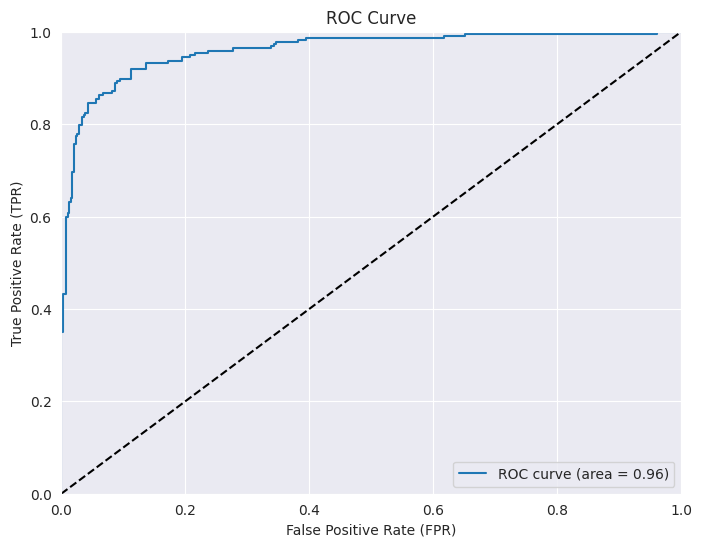

In [14]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")
# Make predictions on the test data
y_pred = model.predict(x_test)

# Calculate the ROC-AUC score
roc_auc = roc_auc_score(y_test, y_pred)

# Get the FPR, TPR, and threshold values for plotting the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal reference line (random classifier)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

Validation Accuracy: 0.7500
Test Accuracy: 0.7821


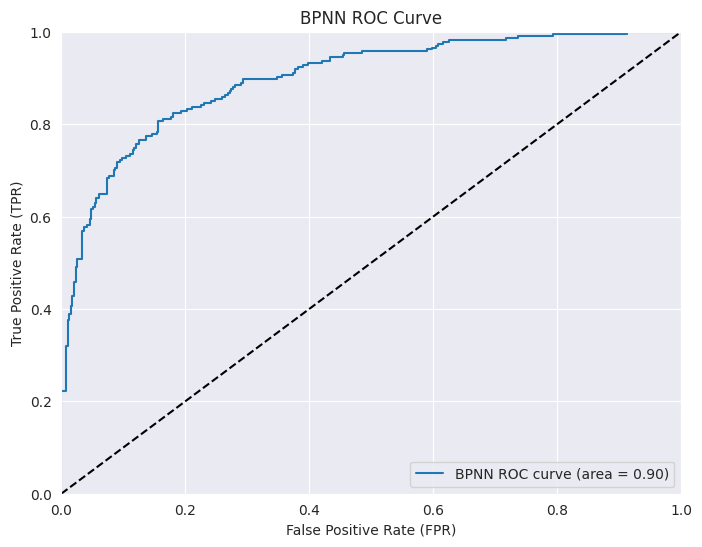

In [78]:
# Reshape the data for BPNN
x_train_flattened = x_train.reshape(x_train.shape[0], -1)
x_val_flattened = x_val.reshape(x_val.shape[0], -1)
x_test_flattened = x_test.reshape(x_test.shape[0], -1)


# Normalize the feature vectors
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_flattened)
x_val_scaled = scaler.transform(x_val_flattened)
x_test_scaled = scaler.transform(x_test_flattened)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=50, random_state=42)
x_train_pca = pca.fit_transform(x_train_scaled)
x_val_pca = pca.transform(x_val_scaled)
x_test_pca = pca.transform(x_test_scaled)

# Hyperparameter tuning using GridSearchCV for BPNN
bpnn = MLPClassifier(hidden_layer_sizes=(50,), max_iter=1000, alpha=0.0001,
                     solver='adam', random_state=42, activation='relu')
bpnn.fit(x_train_pca, y_train)

# Predict on the validation set
test_predictions = bpnn.predict(x_val_pca)
test_accuracy = np.mean(test_predictions == y_val)
print(f"Validation Accuracy: {test_accuracy:.4f}")

# Predict on the test set
test_predictions = bpnn.predict(x_test_pca)
test_accuracy = np.mean(test_predictions == y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Predict probabilities for the positive class (Pneumonia) using BPNN model
y_prob_bpnn_pneumonia = bpnn.predict_proba(x_test_pca)[:, 1]

# Calculate the ROC-AUC score for BPNN model
roc_auc_bpnn = roc_auc_score(y_test, y_prob_bpnn_pneumonia)

# Get the FPR, TPR, and threshold values for plotting the ROC curve
fpr_bpnn, tpr_bpnn, thresholds_bpnn = roc_curve(y_test, y_prob_bpnn_pneumonia)

# Plot the ROC curve for BPNN model
plt.figure(figsize=(8, 6))
plt.plot(fpr_bpnn, tpr_bpnn, label='BPNN ROC curve (area = %0.2f)' % roc_auc_bpnn)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal reference line (random classifier)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('BPNN ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [48]:
# Reshape the data for KNN
x_train_flattened = x_train.reshape(x_train.shape[0], -1)
x_val_flattened = x_val.reshape(x_val.shape[0], -1)
x_test_flattened = x_test.reshape(x_test.shape[0], -1)

# Normalize the feature vectors
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_flattened)
x_val_scaled = scaler.transform(x_val_flattened)
x_test_scaled = scaler.transform(x_test_flattened)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=50, random_state=42)
x_train_pca = pca.fit_transform(x_train_scaled)
x_val_pca = pca.transform(x_val_scaled)
x_test_pca = pca.transform(x_test_scaled)

# Hyperparameter tuning using GridSearchCV
knn = KNeighborsClassifier()
param_grid = {
    "n_neighbors": [1, 2, 3, 5, 7, 10],
    "p": [1, 2]
}
grid_search = GridSearchCV(knn, param_grid, cv=3)
grid_search.fit(x_train_pca, y_train)
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Create an ensemble of KNN models
ensemble_models = []
for i in range(5):
    knn_model = KNeighborsClassifier(n_neighbors=best_params["n_neighbors"], p=best_params["p"])
    ensemble_models.append(('knn'+str(i), knn_model))

# Create the ensemble voting classifier
voting_classifier = VotingClassifier(ensemble_models, voting='soft')

# Fit the voting classifier on the training data
voting_classifier.fit(x_train_pca, y_train)

# Predict on the validation set
val_predictions = voting_classifier.predict(x_val_pca)
val_accuracy = accuracy_score(y_val, val_predictions)
print("Validation Accuracy:", val_accuracy)

# Predict on the test set
test_predictions = voting_classifier.predict(x_test_pca)
test_accuracy = accuracy_score(y_test, test_predictions)
print("Test Accuracy:", test_accuracy)

Validation Accuracy: 0.6875
Test Accuracy: 0.7564102564102564


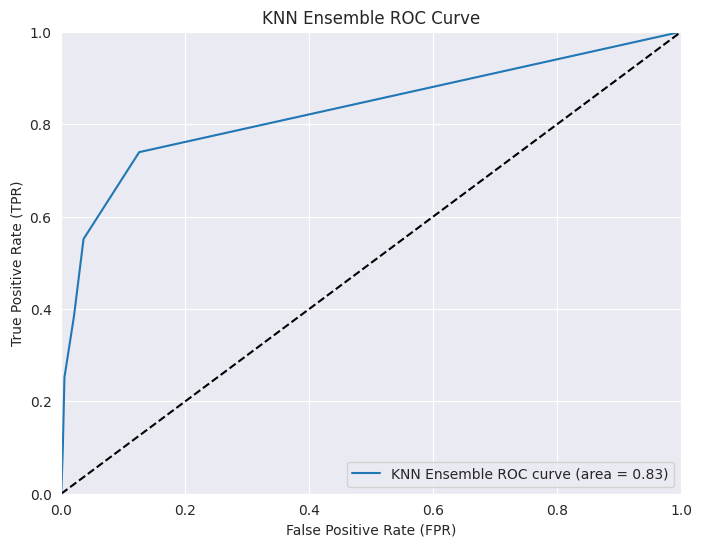

In [49]:
y_pred_knn = voting_classifier.predict_proba(x_test_pca)[:, 1]

# Calculate the ROC-AUC score
roc_auc_knn = roc_auc_score(y_test, y_pred_knn)

# Get the FPR, TPR, and threshold values for plotting the ROC curve
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test, y_pred_knn)

# Plot the ROC curve for KNN Ensemble model
plt.figure(figsize=(8, 6))
plt.plot(fpr_knn, tpr_knn, label='KNN Ensemble ROC curve (area = %0.2f)' % roc_auc_knn)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal reference line (random classifier)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('KNN Ensemble ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [50]:

# Normalize the feature vectors
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_flattened)
x_val_scaled = scaler.transform(x_val_flattened)
x_test_scaled = scaler.transform(x_test_flattened)

# Build the Gaussian Naive Bayes model
nb_model = GaussianNB()

# Fit the model on the training data
nb_model.fit(x_train_scaled, y_train)

# Predict on the validation set
val_predictions = nb_model.predict(x_val_scaled)
val_accuracy = accuracy_score(y_val, val_predictions)
print("Validation Accuracy:", val_accuracy)

# Predict on the test set
test_predictions = nb_model.predict(x_test_scaled)
test_accuracy = accuracy_score(y_test, test_predictions)
print("Test Accuracy:", test_accuracy)

Validation Accuracy: 0.6875
Test Accuracy: 0.7291666666666666


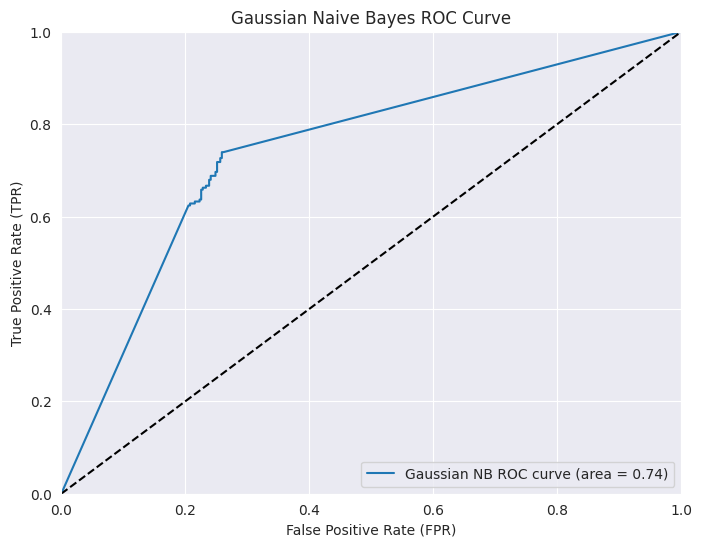

In [51]:
y_pred_nb = nb_model.predict_proba(x_test_scaled)[:, 1]

# Calculate the ROC-AUC score
roc_auc_nb = roc_auc_score(y_test, y_pred_nb)

# Get the FPR, TPR, and threshold values for plotting the ROC curve
fpr_nb, tpr_nb, thresholds_nb = roc_curve(y_test, y_pred_nb)

# Plot the ROC curve for Gaussian Naive Bayes model
plt.figure(figsize=(8, 6))
plt.plot(fpr_nb, tpr_nb, label='Gaussian NB ROC curve (area = %0.2f)' % roc_auc_nb)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal reference line (random classifier)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Gaussian Naive Bayes ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()